 ## Probabilistic Programming from Scratch 3: Performance and PyMC3

https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-3-improving-algorithmic-performance-and-online-learning

- What probabilistic programming truly means?
- Bayesian method's value in probabilistic programming
- ABC quantifies risk, inserts institutional knowledge, and handles on-line learning
- Compare the qualities of a custom-built ABC based system vs. off-the-shelf PyMC3

>> Approximate Bayesian Computation is a brute force algorithm. It works, but it's not quick. We're going to:

### APPROXIMATE BAYESIAN COMPUTATION REFRESHER

In [23]:
import itertools
import random

def abayes(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p


# prior_sampler
def uniform_prior_sampler():
    '''Yield random numbers in interval (0, 1).'''
    while True:
        yield random.random()

# simulate
def simulate_conversion(p, n_visitors):
    '''Return number of vistors who convert given conversion fraction p.'''
    return sum(random.random() < p for _ in range(n_visitors))

# compare
def compare_conversion(sim, obs):
    '''Return True if two observations are the same.'''
    return sim == obs

# take to take a specific number of samples from a generator and load them as a list.
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

In [24]:
posterior_sampler = abayes(
    data=4,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 100),
    compare=compare_conversion)

%timeit take(1, posterior_sampler)

1.91 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
# What if we have ten times as many conversions and visitors: 40/1000

posterior_sampler_big = abayes(
    data=40,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 1000),
    compare=compare_conversion)

%timeit take(1, posterior_sampler_big)

177 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> We need thousands of samples from the posterior to build up a complete picture of the posterior distribution.

#### IMPROVING PERFORMANCE
> We can do this by changing the compare function to give it some "fuzziness", 

In [26]:
def compare_conversion_fuzzy(sim, obs, tol=0.1):
    '''Return True if two observations agree within a relative tolerance.'''
    return abs(sim - obs)/(sim + 1.0) < tol

> This function returns True if the difference between sim and obs is less than 10% of the value of sim. The +1 is in there to make sure we don't divide by zero.

In [27]:
posterior_sampler_big_fuzzy = abayes(
    data=40,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 1000),
    compare=compare_conversion_fuzzy)

%timeit take(1, posterior_sampler_big_fuzzy)

print("\n That's a big speedup of a factor of 10 or so \n ")

20.7 ms ± 7.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

 That's a big speedup of a factor of 10 or so 
 


> fuzzy comparison means that you get a fuzzy posterior. 
>> The peak will be in the right place, but it will be smeared out.

In [28]:
nsamples = 100
a_samples = take(nsamples, posterior_sampler_big)
a_samples_fuzzy = take(nsamples, posterior_sampler_big_fuzzy)

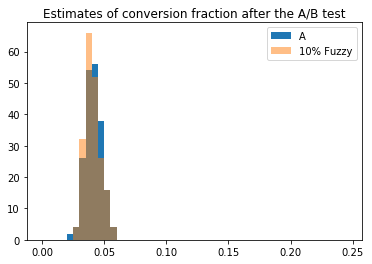

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(a_samples_fuzzy, bins=abbins, label='10% Fuzzy', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

***

#### THE GERMAN TANK PROBLEM

- German tanks were assigned a serial number when they rolled off the production line 
- The first tank was number 0, the next was number 1, and so on, up to n_tanks-1
- __The question is__: given those n_caught serial numbers, how many tanks does Germany have, i.e. what is n_tanks?

### To use our function abayes() we need the four arguments:

1. data
2. a generator that yields samples from the prior
3. a function to simulate the data given values of n_tanks and n_caught
4. a function to compare the data with the outcome of a simulation

> Let's assume the Allies catch two tanks and these have these serial numbers.
>> Next, the generator to get samples from the prior. The Allies know the Germans have at least max(captured_tanks) tanks.

In [30]:
captured_tanks = [314, 421]
max_upper=5000

In [31]:
def prior_ntanks_sampler(captured_tanks, upper=max_upper):
    '''Yield random integers in the range (max(captured_tanks), upper).'''
    while True:
        yield random.randint(max(captured_tanks), upper)

>> Now a function to simulate the data, assuming there are N tanks, and the Allies catch m.

>>Note that this function uses sample which ensures that we don't get the same number twice. You can't capture a tank twice.

In [32]:
def simulate_tanks(n_tanks, n_caught):
    '''Return serial numbers of n_caught tanks given there are a total of n_tanks.'''
    return random.sample(range(n_tanks), n_caught)

> Finally, we need a function to compare the serial numbers of the observed tanks and the results of a simulation.

>> Again, to speed things up, we'll give our function a tolerance, so that the simulation needs to be similar to the data, rather than identical.

In [33]:
def compare_tanks(obs1, obs2, tol=20):
    '''Return True if two sets of serial numbers agree within a tolerance.'''
    return all(abs(o1 - o2) <= tol 
               for o1, o2 in zip(sorted(obs1), sorted(obs2)))

>> Now we're all set to run abayes and draw 1000 samples from the posterior distribution for the number of tanks.

In [34]:
posterior_ntanks_sampler = abayes(
    captured_tanks,
    prior_ntanks_sampler(captured_tanks),
    lambda n_tanks: simulate_tanks(n_tanks, len(captured_tanks)),
    compare_tanks)

tank_samples = take(1000, posterior_ntanks_sampler)

>> overplot the analytic solution to this problem. This is the known correct answer 

In [35]:
from math import factorial


def binom(x, y):
    '''Return binomial coefficient for x, y.'''
    return factorial(x)//(factorial(y) * factorial(x - y))


def analytic_solution(n_tanks, captured_tanks):
    '''Probability that there are n_tanks given a list of captured serial numbers.'''
    k = len(captured_tanks)
    if k < 2:
        raise ValueError("Analytic formula valid for len(captured_tanks) >= 2.".format(k))
    m = max(captured_tanks)
    if n_tanks < m:
        return 0.0
    else:
        return (k - 1)/k * binom(m - 1, k - 1)/binom(n_tanks, k)

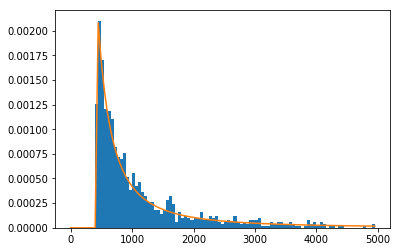

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

tank_bins = range(0, 5000, 50)
plt.hist(tank_samples, normed=True, bins=tank_bins)
plt.plot(tank_bins, [analytic_solution(x, captured_tanks) for x in tank_bins]);

## what's the probability that Germany has more than 1000 tanks.

In [38]:
pro=sum(t > 1000 for t in tank_samples)/len(tank_samples)
print( "The probability that Germany has more than 1000 tanks = ", pro)



The probability that Germany has more than 1000 tanks =  0.377


***

__Probabilistic programming__ is an approach to language or library design that hides the complexity of solving an inference problem.

> all you have to do is write two functions and a generator.
> need to graduate to industrial strength sampling algorithms.
> The best-known examples are:

1. __Markov Chain Monte Carlo__ [Link](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/)     (which includes Metropolis Hastings and Gibbs sampling) 

2. __Hamiltonian Monte Carlo__  [link](https://www.safaribooksonline.com/oriole/(http://blog.fastforwardlabs.com/2017/01/30/the-algorithms-behind-probabilistic-programming.html)

3. __ADVI__

** These are super fast, but fragile and tough to implement.**

> using an off-the-shelf probabilistic programming system called PyMC3. It's not only orders of magnitude faster, it also makes specifying your simulation process much easier because fundamental ideas like random variables and distributions are primitive objects that can be composed together

In [41]:
from pymc3 import DiscreteUniform, Model, sample

with Model():
    n_tanks = DiscreteUniform('n_tanks', lower=max(captured_tanks), upper=5000)
    obs = DiscreteUniform('obs', lower=0, upper=n_tanks, observed=captured_tanks) 
    trace = sample(10000)

C:\Users\iabualhaol\AppData\Local\Theano\compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.2-64\lazylinker_ext\mod.cpp:1:0: sorry, unimplemented: 64-bit mode not compiled in



00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

AttributeError: module 'theano' has no attribute 'gof'

 >>> If you go back in this notebook and add more tanks to captured_tanks, the speed difference becomes even starker

In [ ]:
burn_in = 1000
plt.hist(trace[burn_in:].get_values('n_tanks'), normed=True, bins=100)
plt.plot(tank_bins, [analytic_solution(x, captured_tanks) for x in tank_bins]);

In [44]:
def estimate_conversion(n_visitors, n_conv, trial_conversion, n_estimates=5000):
    '''
    Return n_estimates estimates of the conversion fraction of a layout that 
    received n_visitors, n_conv of which converted.
    '''
    i = 0
    estimates = []
    while i < n_estimates:
        p = trial_conversion()
        n_sim = simulate_conversion(p, n_visitors)
        if n_conv == n_sim:
            estimates.append(p)
            i += 1
    return estimates

In [45]:
n_visitors_a = 100  # number of visitors shown layout A
n_conv_a = 4        # number of vistors shown layout A who converted (4%)

n_visitors_b = 40  
n_conv_b = 2

a_estimates = estimate_conversion(n_visitors_a, n_conv_a, trial_conversion_a)
len(a_estimates)

5000

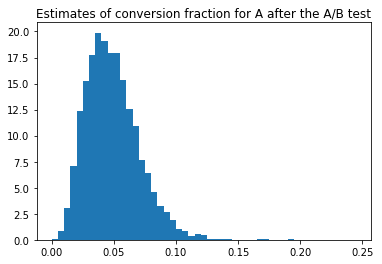

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25

plt.hist(a_estimates, bins=abbins, normed=True)
plt.title('Estimates of conversion fraction for A after the A/B test');

In [97]:
def trial_conversion_b():
    '''Return a random number around 0.06+/-0.02.'''
    while True:
        x = random.normalvariate(mu=0.06, sigma=0.02)
        if 0 <= x <= 1:
            return x

trial_conversion_b()

0.06549833933390767

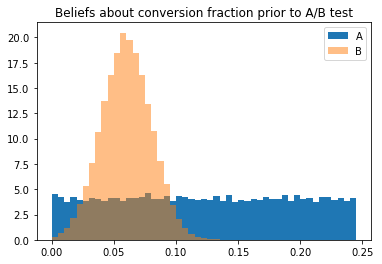

In [98]:
trial_as = [trial_conversion_a() for _ in range(100000)]
trial_bs = [trial_conversion_b() for _ in range(100000)]

plt.hist(trial_as, bins=abbins, label='A', normed=True)
plt.hist(trial_bs, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Beliefs about conversion fraction prior to A/B test')
plt.legend();

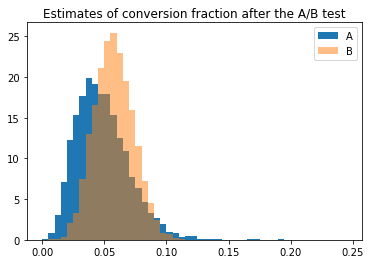

In [103]:
b_estimates = estimate_conversion(n_visitors_b, n_conv_b, trial_conversion_b)
plt.hist(a_estimates, bins=abbins, label='A', normed=True)
plt.hist(b_estimates, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

### THE ANSWER TO THE A/B TEST


In [104]:
b_better = [b > a for a, b in zip(a_estimates, b_estimates)]
#print(b_better[:10])
print("\n\nOur confidence that B is better than A = {} \n"\
      .format(sum(b_better)/len(b_better)))



Our confidence that B is better than A = 0.655 



>If layout B would cost us $1m, perhaps this is not confident enough to risk the change. In that case, we'd run the A/B test for longer, and hopefully become more confident.



>You can use a_estimates and b_estimates to answer some arbitrary questions. Go back and change the code in the last couple of cells and figure out the probability that the conversion fraction of layout A is greater than 6%?

In [105]:
#  The probability that the conversion fraction 
#   of layout A is greater than 6%?
sum([i>0.06 for i in a_estimates])/len(a_estimates)

0.2674

> Here's another question. Let's say we'll only bother to switch to layout B if it's at least 1% better than layout A. What's the probability this is true?



In [106]:

switch_b= [(b-a)/a >=.01 for a, b in zip(a_estimates, b_estimates)]
sum(switch_b)/len(a_estimates)

0.6492

> Now, about those prior beliefs. The middle of the distribution of b_estimates is actually a little closer to 0.06, the value favored by the prior than to 0.05, the value favored by the data.

>>First, measure exactly how much closer by determining the mean of that list.

>>>See if you can figure out why it's closer to the value favored by the prior than that favored by the data? Here's a clue: what happens if you increase the number of visitors who see layout B by a factor of say 10 (and the number who convert by the same factor)?

In [112]:
n_visitors_b = 40*10
n_conv_b = 2*10
n_visitors_b, n_conv_b= n_visitors_b*1, n_conv_b*1
b_estimates = estimate_conversion(n_visitors_b, n_conv_b, trial_conversion_b)

import numpy as np
np.mean(b_estimates)

0.053647647158831115